<h1>Data Cleaning and Organizing for London Housing Dataset</h1>
<p>Here I'm going to walk through the basic steps of wrangling a new dataset into something more suitable for analysis. I'll show data loading, initial inspection, a little bit of EDA, missing data handling, resampling, and the creation of a new combined DataFrame.</p>

In [15]:
#load basic packages, define data locations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

monthly_data = './Data/housing_in_london_monthly_variables.csv'
yearly_data = './Data/housing_in_london_yearly_variables.csv'

In [16]:
m_df = pd.read_csv(monthly_data)
y_df = pd.read_csv(yearly_data)

print('Monthly data preview:')
print(m_df.head())

print('--------------------------------------------------------------------------------------------')

print('Yearly data preview:')
print(y_df.head())

Monthly data preview:
         date            area  average_price       code  houses_sold  \
0  1995-01-01  city of london          91449  E09000001         17.0   
1  1995-02-01  city of london          82203  E09000001          7.0   
2  1995-03-01  city of london          79121  E09000001         14.0   
3  1995-04-01  city of london          77101  E09000001          7.0   
4  1995-05-01  city of london          84409  E09000001         10.0   

   no_of_crimes  borough_flag  
0           NaN             1  
1           NaN             1  
2           NaN             1  
3           NaN             1  
4           NaN             1  
--------------------------------------------------------------------------------------------
Yearly data preview:
        code                  area        date  median_salary  \
0  E09000001        city of london  1999-12-01        33020.0   
1  E09000002  barking and dagenham  1999-12-01        21480.0   
2  E09000003                barnet  1999-12-

<h1>First Impressions</h1>
<h2>Monthy Data</h2>
<p>We'll do some plotting soon to verify this, but as the most important first check, it looks like the monthly data is indeed monthly. Judging from the fact that the first five rows increase in monthly increments but all have an area ID of "city of london", this table may be grouped first by area, then by time. It looks like some columns will need a bit of explaining and/or reorganizing, and others have huge variance or missing data.</p>
<h2>Yearly Data</h2>
<p>The yearly data looks a bit sloppier at first glance. We see a lot more missing values. The issue of huge variance in some columns is here as well, plus a few columns with suspect values. For example, life satisfaction only ranges from 7 to 8. If we do more advanced analyses on those numbers, they will need to be scaled.</p>
<p>Now let's investigate the data a little more closely by plotting the average housing price, number of houses sold, and number of crimes over time by area. These plotly figures can be interacted with by mousing over lines or double clicking on the legend.</p>

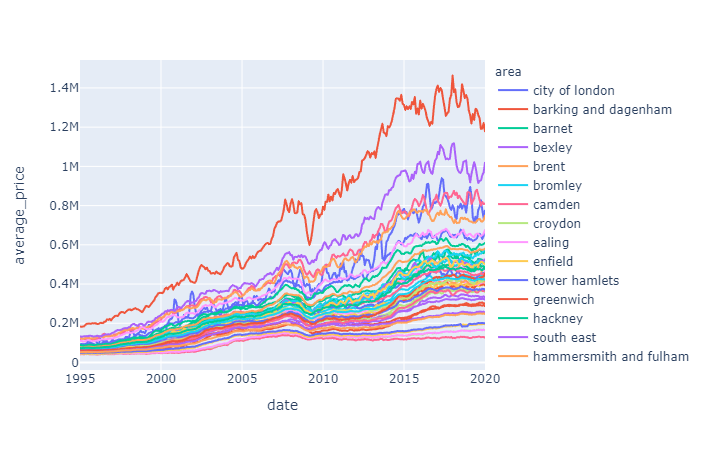

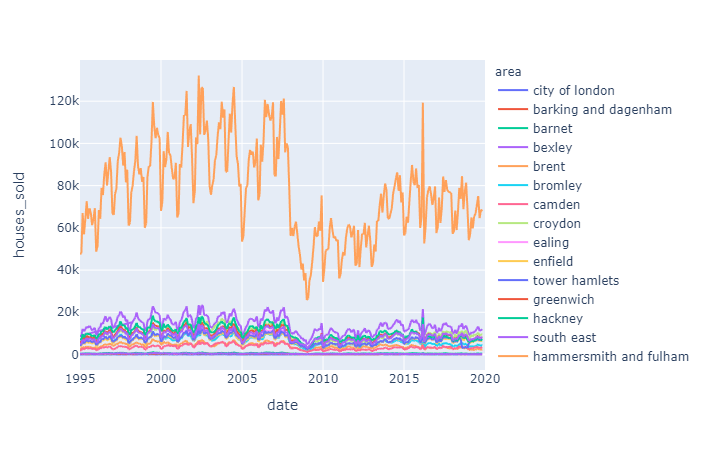

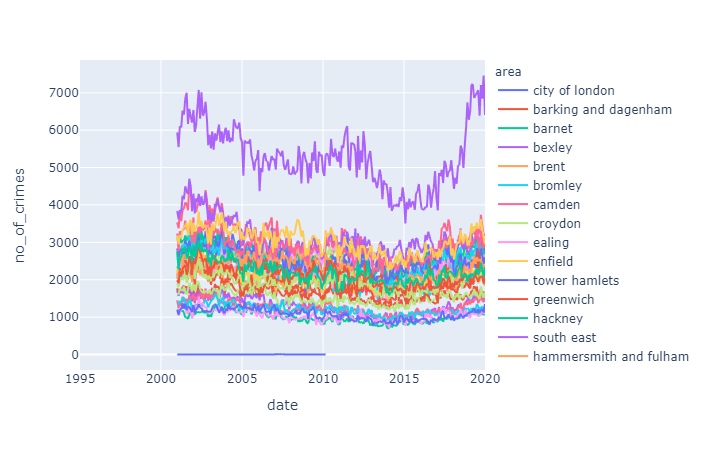

In [17]:
#Housing prices by month
temp_df = m_df[['date','area','average_price']]
fig = px.line(temp_df, x="date", y="average_price", color='area')
fig.show()

#houses sold
temp_df = m_df[['date','area','houses_sold']]
fig = px.line(temp_df, x="date", y="houses_sold", color='area')
fig.show()

#no. of crimes
temp_df = m_df[['date','area','no_of_crimes']]
fig = px.line(temp_df, x="date", y="no_of_crimes", color='area')
fig.show()

<h1>Cleaning and Organizing Based on Initial Observations</h1>
<p>Before we can start looking at correlations, predictions, etc., we should take note of a few important things here.</p>
<h2>Summary areas</h2>
<p>First, some areas have been included as sums or averages of other areas. Examples include "england", "city of london", and "south east". These may be intermittently useful, such as for setting a baseline to compare more specific areas to. But some of them are not adequately documented. Crimes in "city of london" show up in single digits or even 0, which can't be right. So for EDA purposes we'll remove these from our active dataframes by looking for the borough_flag identifier to let us know if something is an area of London.</p>
<h2>Missing data</h2>
<p>Some data wasn't collected for the first several years of the project, or have missing individual datapoints. For EDA purposes, we should just note when data collection began later (as in number of crimes). If we find individual missing numbers, we can perform a simple linear interpolation to impute those numbers.</p>
<h2>Move to yearly</h2>
<p>Finally, we would like to even out the monthly variance by resampling to a yearly measure. Some interesting and useful data can be gleaned from monthly measures, such as peak buying in the summer and the lowest number of purchases in the winter. But real estate data is generally going to show much more movement over several years than several months. There are also some yearly measures we would like to directly compare to monthly data.</p>
<h2>Next steps</h2>
<p>So our next steps are:
    <ul>
        <li>Remove areas with a borough_flag of 0</li>
        <li>Add windowed linear interpolation to fill in missing data where appropriate</li>
        <li>Resample monthly data to annual</li>
        <li>Create combined annually-sampled df</li>
    </ul>
</p>

In [18]:
#remove rows that are not boroughs
m_boroughs = m_df[m_df.borough_flag != 0]
y_boroughs = y_df[m_df.borough_flag != 0]

m_boroughs = m_boroughs[m_boroughs.area != 'city of london']
y_boroughs = y_boroughs[y_boroughs.area != 'city of london']

C:\Users\Joey\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [19]:
#interpolate missing data (we could similarly do fillna() with a replacement function, but this is a little 
#better for timeseries)
#copy boroughs df
m_int_b = m_boroughs.copy()
y_int_b = y_boroughs.copy()

#interpolate column data
m_int_b['average_price'] = m_boroughs['average_price'].interpolate(method='linear',axis=0,limit=3,limit_direction='both',limit_area='inside')
m_int_b['houses_sold'] = m_boroughs['houses_sold'].interpolate(method='linear',axis=0,limit=3,limit_direction='both',limit_area='inside')
m_int_b['no_of_crimes'] = m_boroughs['no_of_crimes'].interpolate(method='linear',axis=0,limit=3,limit_direction='both',limit_area='inside')

y_int_b['median_salary'] = y_boroughs['median_salary'].interpolate(method='linear',axis=0,limit=3,limit_direction='both',limit_area='inside')
y_int_b['life_satisfaction'] = y_boroughs['life_satisfaction'].interpolate(method='linear',axis=0,limit=3,limit_direction='both',limit_area='inside')
y_int_b['population_size'] = y_boroughs['population_size'].interpolate(method='linear',axis=0,limit=3,limit_direction='both',limit_area='inside')
y_int_b['number_of_jobs'] = y_boroughs['number_of_jobs'].interpolate(method='linear',axis=0,limit=3,limit_direction='both',limit_area='inside')
y_int_b['no_of_houses'] = y_boroughs['no_of_houses'].interpolate(method='linear',axis=0,limit=3,limit_direction='both',limit_area='inside')


In [20]:
#resample monthly data to yearly
#first need to make a multi-index: Area and Date
m_int_b.set_index(['area', 'date'],inplace=True)
#reassign date index as datetime (initially set as int)
#needed for temporal resampling
m_int_b.index = m_int_b.index.set_levels([m_int_b.index.levels[0], pd.to_datetime(m_int_b.index.levels[1])])
print(m_int_b.head())

                                 average_price       code  houses_sold  \
area                 date                                                
barking and dagenham 1995-01-01          50460  E09000002         96.0   
                     1995-02-01          51086  E09000002         95.0   
                     1995-03-01          51269  E09000002        144.0   
                     1995-04-01          53134  E09000002        109.0   
                     1995-05-01          53042  E09000002        149.0   

                                 no_of_crimes  borough_flag  
area                 date                                    
barking and dagenham 1995-01-01           NaN             1  
                     1995-02-01           NaN             1  
                     1995-03-01           NaN             1  
                     1995-04-01           NaN             1  
                     1995-05-01           NaN             1  


In [21]:
#need Grouper to resample effectively on multi-index
s = m_int_b['average_price'].groupby(['area']+[pd.Grouper(freq='1Y', level=1)]).mean()

#here's an example of what that looks like for one column:
print(s.head())

#will need to treat columns differently based on required aggregate function
#another problem is that the resampled dates fall on 12/31 of the year, but yearly measures fall on 12/01
#they won't match neatly in a combined dataframe, so we'll need to fix that
print(y_int_b['date'].head())

area                  date      
barking and dagenham  1995-12-31    51818.000000
                      1996-12-31    51718.250000
                      1997-12-31    55974.250000
                      1998-12-31    60285.750000
                      1999-12-31    65320.833333
Name: average_price, dtype: float64
1    1999-12-01
2    1999-12-01
3    1999-12-01
4    1999-12-01
5    1999-12-01
Name: date, dtype: object


In [22]:
#Assign resampled data to new df
res_m_int_b = pd.DataFrame()
res_m_int_b['mean_average_price'] = m_int_b['average_price'].groupby(['area']+[pd.Grouper(level=-1,freq='1Y',axis=0)]).mean()
res_m_int_b['sum_houses_sold'] = m_int_b['houses_sold'].groupby(['area']+[pd.Grouper(level=-1,freq='1Y',axis=0)]).sum()
res_m_int_b['sum_crimes'] = m_int_b['no_of_crimes'].groupby(['area']+[pd.Grouper(level=-1,freq='1Y',axis=0)]).sum()

#preserve nans - 0 crimes annually is untrue and misleading
res_m_int_b['sum_crimes'].replace(0,np.nan,inplace=True)

res_m_int_b.head()

mean_average_price  sum_houses_sold  \
area                 date                                              
barking and dagenham 1995-12-31        51818.000000           1476.0   
                     1996-12-31        51718.250000           1881.0   
                     1997-12-31        55974.250000           2434.0   
                     1998-12-31        60285.750000           2496.0   
                     1999-12-31        65320.833333           2686.0   

                                 sum_crimes  
area                 date                    
barking and dagenham 1995-12-31         NaN  
                     1996-12-31         NaN  
                     1997-12-31         NaN  
                     1998-12-31         NaN  
                     1999-12-31         NaN

In [23]:
#Do some rearranging so that we just use the year as level 1 index instead of date
#allows us to join this to the yearly data after we do the same for that df
res_m_int_b.reset_index(inplace=True)
index_years = pd.to_datetime(res_m_int_b['date']).dt.year
res_m_int_b['year'] = index_years
res_m_int_b.set_index(['area','year'],inplace=True)
res_m_int_b.drop(columns='date',inplace=True)
res_m_int_b.head()

mean_average_price  sum_houses_sold  sum_crimes
area                 year                                                 
barking and dagenham 1995        51818.000000           1476.0         NaN
                     1996        51718.250000           1881.0         NaN
                     1997        55974.250000           2434.0         NaN
                     1998        60285.750000           2496.0         NaN
                     1999        65320.833333           2686.0         NaN

In [24]:
#rearrange index to [Area, Year] to match monthly data
y_int_b.reset_index(inplace=True)
index_years = pd.to_datetime(y_int_b['date']).dt.year
y_int_b['year'] = index_years
y_int_b.sort_values(by=['area','year'],inplace=True)
y_int_b.set_index(['area','year'],inplace=True)
y_int_b.drop(columns=['index','date'],inplace=True)
#Now that our indices are the same, we can join our dfs
y_int_b.head(5)

code  median_salary  life_satisfaction  \
area                 year                                                
barking and dagenham 1999  E09000002        21480.0                NaN   
                     2000  E09000002        22618.0                NaN   
                     2001  E09000002        22323.0                NaN   
                     2002  E09000002        24813.0                NaN   
                     2003  E09000002        25358.0                NaN   

                          mean_salary recycling_pct  population_size  \
area                 year                                              
barking and dagenham 1999       23620             3         162444.0   
                     2000       24696             4         163893.0   
                     2001       26050             3         165654.0   
                     2002       26653             3         166357.0   
                     2003       27792             5         166210.0   

                           number_of_jobs  area_size  no_of_houses  \
area                 year                                            
barking and dagenham 1999             NaN        NaN           NaN   
                     2000         57000.0        NaN           NaN   
                     2001         54000.0     3780.0       68298.0   
                     2002         52000.0     3780.0       68526.0   
                     2003         55000.0     3780.0       68837.0   

                           borough_flag  
area                 year                
barking and dagenham 1999             1  
                     2000             1  
                     2001             1  
                     2002             1  
                     2003             1

In [25]:
combined_df = res_m_int_b.join(y_int_b,how='left')
combined_df.head(5)

mean_average_price  sum_houses_sold  sum_crimes  \
area                 year                                                    
barking and dagenham 1995        51818.000000           1476.0         NaN   
                     1996        51718.250000           1881.0         NaN   
                     1997        55974.250000           2434.0         NaN   
                     1998        60285.750000           2496.0         NaN   
                     1999        65320.833333           2686.0         NaN   

                                code  median_salary  life_satisfaction  \
area                 year                                                
barking and dagenham 1995        NaN            NaN                NaN   
                     1996        NaN            NaN                NaN   
                     1997        NaN            NaN                NaN   
                     1998        NaN            NaN                NaN   
                     1999  E09000002        21480.0                NaN   

                          mean_salary recycling_pct  population_size  \
area                 year                                              
barking and dagenham 1995         NaN           NaN              NaN   
                     1996         NaN           NaN              NaN   
                     1997         NaN           NaN              NaN   
                     1998         NaN           NaN              NaN   
                     1999       23620             3         162444.0   

                           number_of_jobs  area_size  no_of_houses  \
area                 year                                            
barking and dagenham 1995             NaN        NaN           NaN   
                     1996             NaN        NaN           NaN   
                     1997             NaN        NaN           NaN   
                     1998             NaN        NaN           NaN   
                     1999             NaN        NaN           NaN   

                           borough_flag  
area                 year                
barking and dagenham 1995           NaN  
                     1996           NaN  
                     1997           NaN  
                     1998           NaN  
                     1999           1.0

<h1>Basic Cleaning Done!</h1>
<p>That about wraps up our basic data cleaning and organization. From here we can write our dataframe to a new csv (not shown here) to load elsewhere for analysis! The specific cleaning tasks would vary based on the end goal, but for a general analysis of annual housing data, this gets us the most important numbers arranged together.</p>